In [5]:
import torch

In [10]:
# setup computational graph
a = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(2.0, requires_grad=True)

x = 3*a + 3*b
y = 6*a*a + 5*b*b*b
z = 3*x + 3*y

In [11]:
z.backward()

In [12]:
print(a.grad)

tensor(117.)


MNIST EXAMPLE

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('../datasets/MNIST/csv/mnist_train.csv')

In [12]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


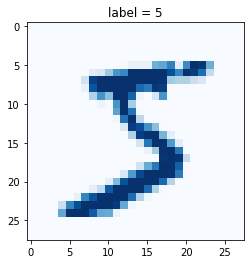

In [17]:
row = 0
data = df.iloc[row]

label = data[0]

img = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')
plt.show()

Simple NN

In [18]:
import torch.nn as nn

In [48]:
class Classifier(nn.Module): #inherit from base class for all neural networks: nn.Module
    def __init__(self): # constructor
        super().__init__() #calling parent class's constructor

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200,  10),
            nn.LeakyReLU(0.2)
        )

        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimizer (SGD is ez)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # forward pass
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item()) # .item() unwraps the tensor to pass just the number
        if self.counter % 10000 == 0:
            print("counter =", self.counter)
        # backwards pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [49]:
c = Classifier()
print(c)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=10, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (loss_function): MSELoss()
)


In [28]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
    

In [29]:
mnist_dataset = MnistDataset('../datasets/MNIST/csv/mnist_train.csv')

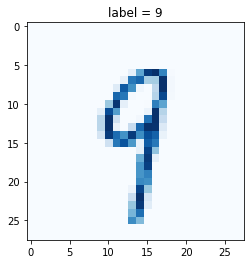

In [31]:
mnist_dataset.plot_image(900)

In [50]:
%%time 
# create neural network
C = Classifier()

# train network on MNIST data set
epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
training epoch 2 of 3
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000
training epoch 3 of 3
counter = 130000
counter = 140000
counter = 150000
counter = 160000
counter = 170000
counter = 180000
CPU times: user 15min 26s, sys: 1.41 s, total: 15min 28s
Wall time: 1min 59s


In [33]:
mnist_test_dataset = MnistDataset('../datasets/MNIST/csv/mnist_test.csv')

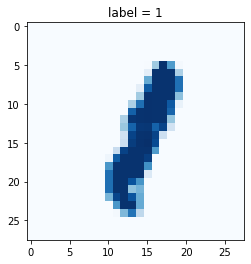

In [37]:
# pick a record
record = 190

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

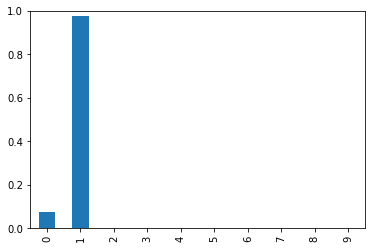

In [51]:
image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data)

# plot output tensor
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [52]:
# test trained neural network on training data
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9647 10000 0.9647
